# Inferring ages from velocities.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Generate ages.

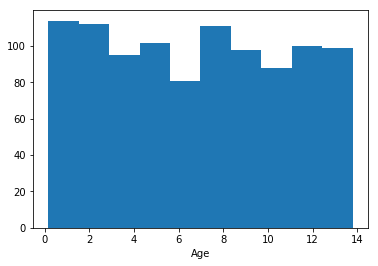

In [39]:
np.random.seed(42)
N = 1000
# ages = (10**np.random.uniform(7, 10.14, N))*1e-9  # Log-uniform age distribution
ages = np.random.uniform(.1, 13.8, N)  # Uniform age distribution
plt.hist(ages);
plt.xlabel("Age");

Use ages and an AVR to generate velocities.
$$\sigma_{vz} = t^\beta $$
$$v_z \sim \mathcal{N}(0, t^\beta)$$

Text(0, 0.5, 'Velocity Dispersion [km/s]')

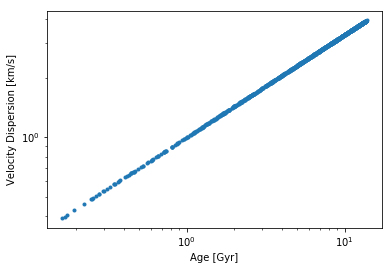

In [40]:
beta = .52
plt.plot(ages, ages**beta, ".")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Age [Gyr]")
plt.ylabel("Velocity Dispersion [km/s]")

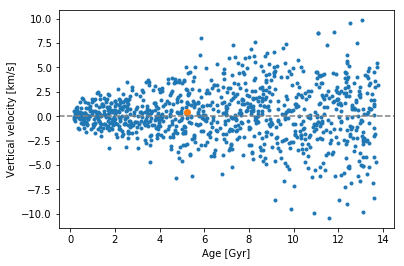

In [41]:
vz = np.random.randn(N)*(ages**beta)
plt.plot(ages, vz, ".", zorder=1)
plt.plot(ages[0], vz[0], "o", zorder=2)
plt.xlabel("Age [Gyr]")
plt.ylabel("Vertical velocity [km/s]")
plt.axhline(0, color=".5", ls="--")

Now take one star and try to infer its age.

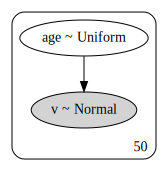

In [110]:
import pymc3 as pm

simple_model = pm.Model()
nstars = 50

with simple_model:
    
    # Prior over age
    age = pm.Uniform("age", lower=0, upper=13.8, shape=nstars)
    
    # Distribution over velocity (Likelihood)
    v = pm.Normal("v", mu=0, sigma=age**.52, observed=vz[:nstars])
    
pm.model_to_graphviz(simple_model)

In [111]:
with simple_model:
    trace = pm.sample(tune=5000, draws=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age]
Sampling 4 chains: 100%|██████████| 40000/40000 [00:15<00:00, 2517.75draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


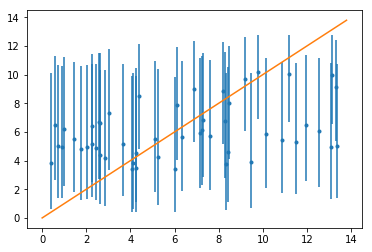

In [112]:
inferred = np.median(trace.age, axis=0)
lower = np.percentile(trace.age, 16, axis=0)
upper = np.percentile(trace.age, 85, axis=0)
yerrp = upper - inferred
yerrm = inferred - lower

plt.errorbar(ages[:nstars], inferred, yerr=[yerrm, yerrp], fmt=".")
xs = np.linspace(0, 13.8, 100)
plt.plot(xs, xs)

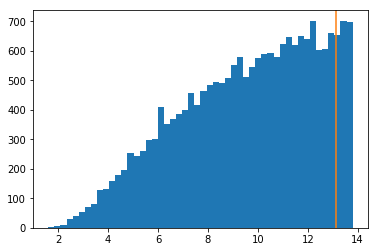

In [93]:
plt.hist(trace.age, 50);
plt.axvline(ages[1], color="C1")

In [84]:
def lnlike(age, v):
    lnlike = -.5*v**2/age**(2*.52)
    if np.isnan(lnlike):
        return -np.inf
    else:
        return lnlike

def lnprior(age):
    if age > 0 and age < 13.8:
        return 0.
    else:
        return -np.inf
    
def lnprob(age, v):
    return lnlike(age, v) + lnprior(age)

print(lnprob(1e-5, 1))

-79244.6596230557


In [86]:
import emcee
from tqdm import trange
ndim, nwalkers, nsteps = 1, 10, 1000
p0 = np.random.randn(nwalkers, ndim)*.1 + 5.

samps = np.zeros((10, nwalkers*nsteps, 1))
for i in trange(10):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[vz[i]])
    sampler.run_mcmc(p0, nsteps);
    samps[i, :, :] = sampler.get_chain(flat=True)

100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


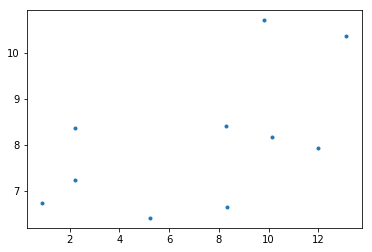

In [90]:
inferred = np.median(samps, axis=1)
plt.plot(ages[:10], inferred, ".")